<a href="https://colab.research.google.com/github/orhanaydinn/brainTumor_Alzheimer_Prediction/blob/main/BrainTumor_Alzheimer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 - Uploaded Dataset**

brain_disease_classification_dataset.zip file upload manually.
```
zip_path = "/content/brain_disease_classification_dataset.zip"
extract_path = "/content/brain_disease_classification_dataset"
```
**zip_path** represents the file path of the uploaded ZIP file.

**extract_path** defines the destination directory where the contents of the ZIP file will be extracted.

In [ ]:
import zipfile
import os

# File and directory paths to extract
zip_path = "/content/brain_disease_classification_dataset.zip"
extract_path = "/content/brain_disease_classification_dataset"

# Open zip file and extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset successfully extracted to:", extract_path)


Dataset successfully extracted to: /content/brain_disease_classification_dataset


Check the loaded datasets before data preparation process.

In [ ]:
for root, dirs, files in os.walk(extract_path):
    print(f"\n{root}")
    for d in dirs:
        print(f"├── {d}")
    for f in files[:5]:
        print(f"├── {f}")


/content/brain_disease_classification_dataset
├── alzheimer
├── tumor

/content/brain_disease_classification_dataset/alzheimer
├── alzheimer_very_mild_demented
├── alzheimer_non_demented
├── alzheimer_moderate_demented
├── alzheimer_mild_demented

/content/brain_disease_classification_dataset/alzheimer/alzheimer_very_mild_demented
├── very_mild_9699.jpg
├── very_mild_11120.jpg
├── very_mild_7582.jpg
├── very_mild_1332.jpg
├── very_mild_110.jpg

/content/brain_disease_classification_dataset/alzheimer/alzheimer_non_demented
├── non_demented_12712.jpg
├── non_demented_9269.jpg
├── non_demented_4890.jpg
├── non_demented_8400.jpg
├── non_demented_2767.jpg

/content/brain_disease_classification_dataset/alzheimer/alzheimer_moderate_demented
├── moderate_2763.jpg
├── moderate_4512.jpg
├── moderate_6477.jpg
├── moderate_4658.jpg
├── moderate_1926.jpg

/content/brain_disease_classification_dataset/alzheimer/alzheimer_mild_demented
├── mild_2062.jpg
├── mild_3349.jpg
├── mild_1455.jpg
├── mild_4

**` def show_random_images(dataset_dir, samples=3):`**
This function displays a random 3 sample images from each class.

**`img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`**
cv2 library create BGR images default setting. This code convert BGR to RGB.



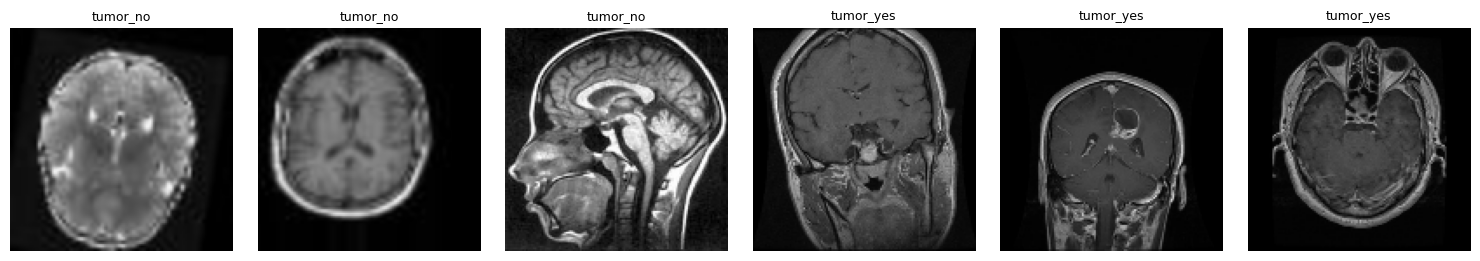

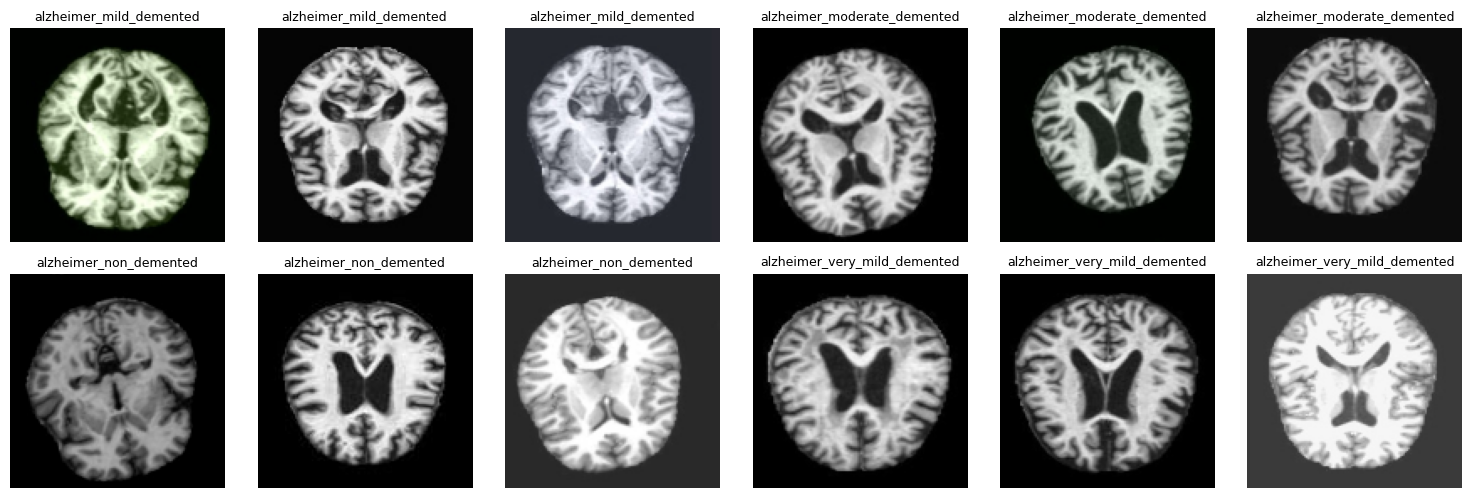

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

IMG_SIZE = 128

def show_random_images(dataset_dir, samples=3):
    class_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

    rows = len(class_folders)
    cols = 6
    plt.figure(figsize=(cols * 2.5, rows * 2.5))
    i = 1
    for label in sorted(class_folders):
        class_path = os.path.join(dataset_dir, label)
        images = os.listdir(class_path)
        random.shuffle(images)

        for img_name in images[:samples]:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            plt.subplot(rows, cols, i)
            plt.imshow(img)
            plt.title(label, fontsize=9)
            plt.axis('off')
            i += 1
    plt.tight_layout()
    plt.show()


# Tumor
show_random_images("/content/brain_disease_classification_dataset/tumor")

# Alzheimer
show_random_images("/content/brain_disease_classification_dataset/alzheimer")


Check the dataset size before pre processing.

                              Tumor  Alzheimer
tumor_no                       6000          0
tumor_yes                      6679          0
alzheimer_mild_demented           0       9856
alzheimer_moderate_demented       0       6528
alzheimer_non_demented            0      12800
alzheimer_very_mild_demented      0      11200


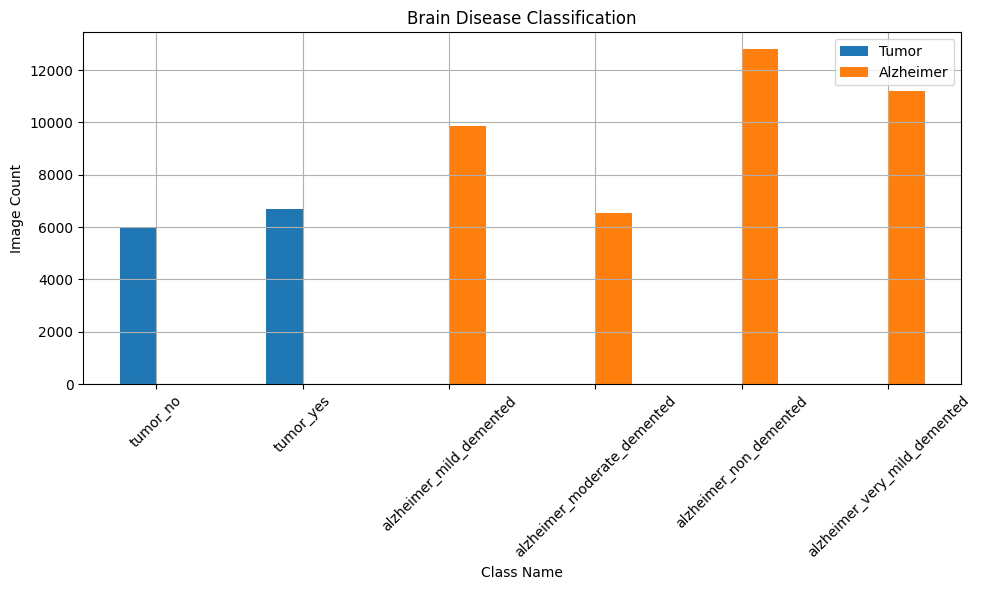

In [ ]:
import pandas as pd
import numpy as np

tumor_dir = "/content/brain_disease_classification_dataset/tumor"
alz_dir = "/content/brain_disease_classification_dataset/alzheimer"

def count_images_in_folders(base_dir):
    class_counts = {}
    for class_name in sorted(os.listdir(base_dir)):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
    return class_counts


tumor_counts = count_images_in_folders(tumor_dir)
alz_counts = count_images_in_folders(alz_dir)


tumor_df = pd.DataFrame.from_dict(tumor_counts, orient='index', columns=['Tumor'])
alz_df = pd.DataFrame.from_dict(alz_counts, orient='index', columns=['Alzheimer'])


df_counts = pd.concat([tumor_df, alz_df], axis=0).fillna(0).astype(int)
print(df_counts)

df_counts.plot(kind="bar", figsize=(10, 6), legend=True)
plt.title("Brain Disease Classification")
plt.ylabel("Image Count")
plt.xlabel("Class Name")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **2 - Tumor Data Preparation & Preprocessing**

In this section, the data was examined and augmentation was applied to some labels.

*   Load and Label Data
*   Read, Resize and Convert Images to Arrays
*   Convert to Numpy Arrays and Normalize the Pixel Values
*   Data Augmentation
    *   Class Distribution Table
    *   Augmentation for **tumor_no** labels
        *   Show Augmentation Images
*   Show Current Dataset




> **Since the models were trained with the latest data, data augmentation was applied already and the dataset was loaded that way. The data augmentation in this section is only representative and is included to show what codes are used.**

## 2.1 - Load and Label Data

**`label_map = {label: idx for idx, label in enumerate(class_names)}`**

This code automatically detects the class folders in the dataset directory and maps each class to a unique integer.

In [ ]:
import os

DATASET_DIR = "/content/brain_disease_classification_dataset/tumor"

# Sınıf isimlerini al ve etiketle
class_names = sorted(os.listdir(DATASET_DIR))
label_map = {label: idx for idx, label in enumerate(class_names)}
print("Label Mapping:", label_map)

Label Mapping: {'tumor_no': 0, 'tumor_yes': 1}


## 2.2 - Read, Resize and Convert Images to Arrays

In this project image size is used 64x64 (`IMG_SIZE = 64`) . Therefore, this code `img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))` resize all of images which are differents size.

In [ ]:
import os
import cv2
import numpy as np


DATASET_DIR = "/content/brain_disease_classification_dataset/tumor"
IMG_SIZE = 64

class_names = sorted(os.listdir(DATASET_DIR))
label_map = {label: idx for idx, label in enumerate(class_names)}


X = []
y = []

for label in class_names:
    class_path = os.path.join(DATASET_DIR, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0
            X.append(img)
            y.append(label_map[label])



## 2.3 - Convert to NumPy Arrays & Normalize the Pixel Values

This code block makes the data types available for model training and normalizes the pixel values ​​of the images.

```
X = np.array(X, dtype='float32')
y = np.array(y)
```
Converts the Python lists X and y into NumPy arrays.

In [ ]:
X = np.array(X, dtype=np.float32)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (12679, 64, 64, 3)
y shape: (12679,)


## 2.4 - Data Augmentation

### 2.4.1 -  Class Distribution Table

### 2.4.2 - Tumor_NO Augmentation

`target_count = 6000` The target number of images was determined as 6000 and the current number of images was subtracted from this number `to_generate = target_count - current_count`.

`for img_name in tqdm(existing_images):` This function generated the required number of images.

```
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)
```


*   Every images was rotated 15°. `rotation_range=15`
*   Zoomed by 10% `zoom_range=0.1`.
*   Slightly shifted horizontally and vertically `width_shift_range=0.1,
height_shift_range=0.1`.
*   Brightness was adjusted between 80% and 120%. `brightness_range=[0.8,1.2]`
*   Some images were flipped horizontally. Empty areas were filled using the nearest pixel method. `horizontal_flip=True, fill_mode='nearest'`


` aug_name = f"aug_tumor_no_{image_idx}.jpg"` This code adds the names **aug_tumor_no_1, aug_tumor_no_2, ..... , aug_tumor_no_n** to the new images

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Settings
target_count = 6000
input_folder = "/content/brain_disease_classification_dataset/tumor/tumor_no"
IMG_SIZE = 64


existing_images = os.listdir(input_folder)
current_count = len(existing_images)
to_generate = target_count - current_count

print(f"Current: {current_count} — Target: {target_count} — Generating: {to_generate}")


image_idx = 1
for img_name in tqdm(existing_images):
    img_path = os.path.join(input_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.reshape((1, IMG_SIZE, IMG_SIZE, 3))

    aug_iter = datagen.flow(img, batch_size=1, save_to_dir=input_folder, save_prefix=f'aug_tumor_no_{image_idx}', save_format='jpeg')

    for _ in range(2):
        if image_idx > to_generate:
            break
        next(aug_iter)
        image_idx += 1

print("The augmentation process is complete.")


Current: 6000 — Target: 6000 — Generating: 0


100%|██████████| 6000/6000 [00:03<00:00, 1912.76it/s]

The augmentation process is complete.


#### 2.4.2.1 - Show Augmentation Images

Check new augmentation 15 images randomly. `sample_imgs = random.sample(aug_images, min(15, len(aug_images)))`

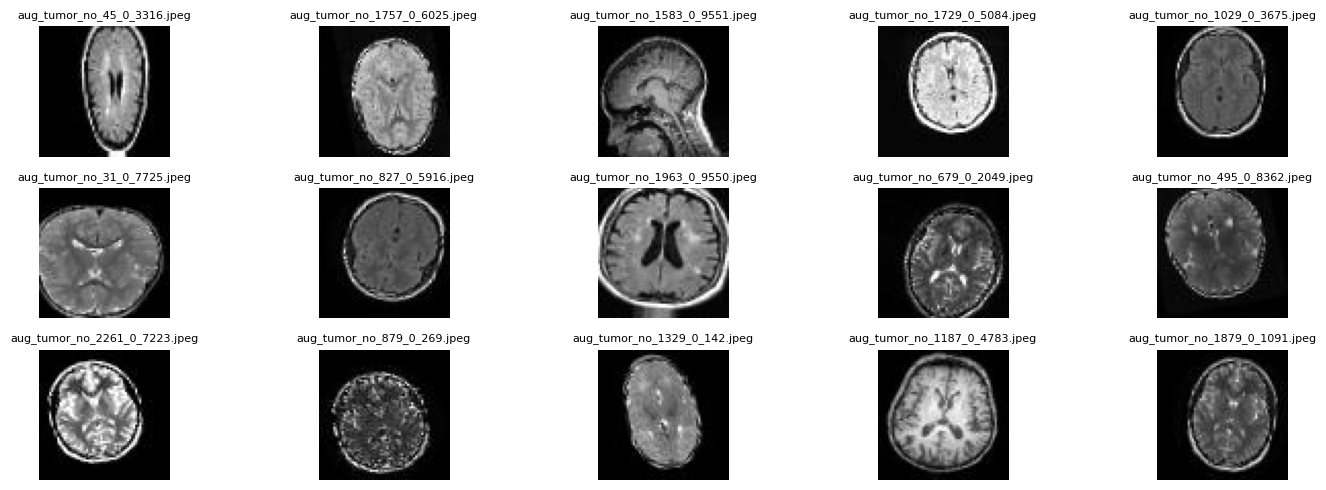

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random


augmented_folder = "/content/brain_disease_classification_dataset/tumor/tumor_no"


aug_images = [img for img in os.listdir(augmented_folder) if img.startswith("aug_")]

# Show random 15 images for augmentation
sample_imgs = random.sample(aug_images, min(15, len(aug_images)))


plt.figure(figsize=(15, 5))
for idx, img_name in enumerate(sample_imgs):
    img_path = os.path.join(augmented_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 5, idx + 1)
    plt.imshow(img)
    plt.title(img_name, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


## 2.5 - Show Current Dataset

After the data augmentation, dataset was controlled and created table which are class and image count.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset path
DATASET_DIR = "/content/brain_disease_classification_dataset/tumor"


class_names = sorted([folder for folder in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, folder))])

# Count images
class_counts = {cls: len([img for img in os.listdir(os.path.join(DATASET_DIR, cls))
                          if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
                for cls in class_names}

# crate Dataframe
df_distribution = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
df_distribution = df_distribution.sort_values("Image Count", ascending=False)

# show table
df_distribution.reset_index(drop=True, inplace=True)
df_distribution


,Class,Image Count
0,tumor_yes,6679
1,tumor_no,6000


<ipython-input-13-dedaca5b84bf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_distribution, x="Class", y="Image Count", palette="mako")


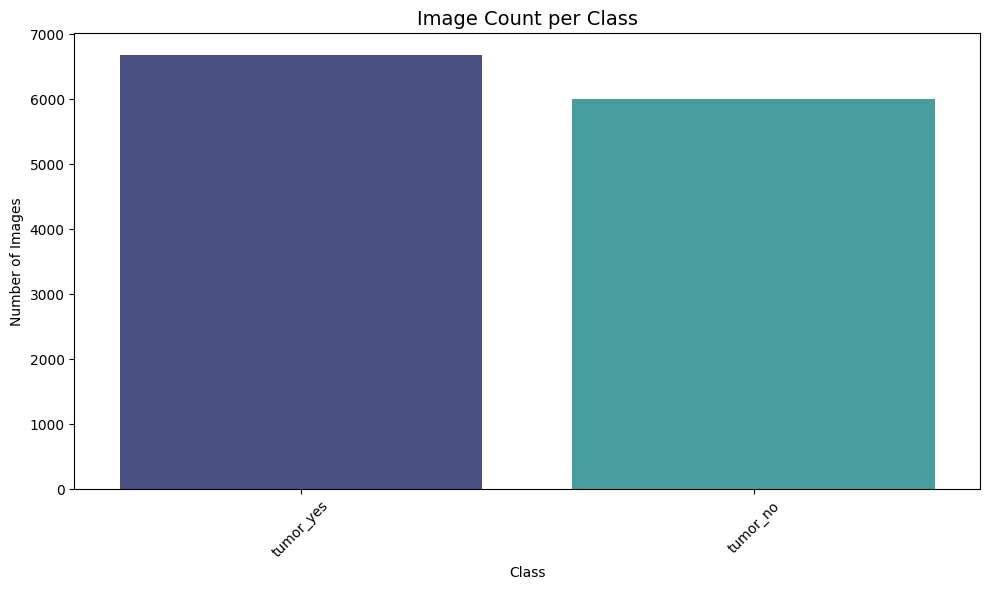

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_distribution, x="Class", y="Image Count", palette="mako")
plt.title("Image Count per Class", fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# **3 - Tumor Model Training & Evaluation**

In this section, CNN and ML models are created and compared for **tumor dataset**.

*   Split Data ( Train / Test )
*   CNN Model
*   CNN Model Training
    *   Training Visualization
    *   Confusion Matrix
*   VGG16 - Transfer Learning Model
*   VGG16 - Transfer Learning Model Training



## 3.1 - Split the Data (Train / Test)

The train and test datasets are separated by 20%.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (10143, 64, 64, 3)
y_train shape: (10143,)


## 3.2 - CNN Model

Base cnn was created for first cnn model.


**CNN - Model Architecture**

```
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
```


*   `Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3))` Aconvolutional layer with 32 filters of size 3x3 and ReLU activation.
*   `Conv2D(64, (3, 3), activation='relu')` Reduces spatial dimensions.

*   `Flatten()` Converts the 2D feature maps into a 1D vector for dense layers.

*    `Dense(128, activation='relu'),` A fully connected layer with 128 units and ReLU activation.

*     `Dropout(0.5)` Drops 50% of the neurons to prevent overfitting.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # output layer
])



**CNN - Model Compilation**

```
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
```

*   `optimizer='adam'` In this project the Adam optimization algorithm was preferred. Adam automatically adapts the learning rate for each parameter separately using first and second moment estimates. This leads to faster and more stable convergence during training.


In [ ]:
# Compile
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # << Doğru olan bu
    metrics=['accuracy']
)


**CNN - EarlyStopping**
```
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
```
Stops training if validation accuracy does not improve for 5 consecutive epochs. Recovers the best weights.


In [ ]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

**CNN - Model Checkpoint**

```
model_checkpoint = ModelCheckpoint(
    filepath='best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
```
Saves the model file with the best validation accuracy. The best validation accuracy was saved "**best_cnn_model_tumor.h5**" in this cnn model. This checkpoint will be used directly in the later stages of the project. There is no need to retrain the model each time it is run from the beginning.


In [ ]:
# Checkpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_cnn_model_tumor.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

## 3.3 CNN Model Training

**CNN - Time Calculation**

```
import time
start = time.time()


end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

```
Starts a timer to measure how long model training takes. After the training, stops the timer and prints total training time in seconds.


**CNN - Model Training**
```
history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)
```



*   `X_train, y_train,` Trains the CNN model using the training data.
*   `epochs=30, batch_size=32` Training was run for 30 epochs, and process 32 images at a time (batch size).
*   `callbacks=[early_stop,` This code can stops training if validation loss doesn’t improve for a few epochs.
*   `callbacks=[  ,model_checkpoint]` Saves the model with the best validation accuracy.
*   `verbose=1` Prints progress of training for each epoch.

In [ ]:
import time
start = time.time()

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.7278 - loss: 0.5300
Epoch 1: val_accuracy improved from -inf to 0.87776, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 68s 413ms/step - accuracy: 0.7283 - loss: 0.5294 - val_accuracy: 0.8778 - val_loss: 0.2820
Epoch 2/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8856 - loss: 0.2751
Epoch 2: val_accuracy improved from 0.87776 to 0.93494, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 87s 444ms/step - accuracy: 0.8857 - loss: 0.2749 - val_accuracy: 0.9349 - val_loss: 0.1762
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9321 - loss: 0.1785
Epoch 3: val_accuracy improved from 0.93494 to 0.94953, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 76s 409ms/step - accuracy: 0.9322 - loss: 0.1785 - val_accuracy: 0.9495 - val_loss: 0.1289
Epoch 4/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9532 - loss: 0.1398
Epoch 4: val_accuracy improved from 0.94953 to 0.96924, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 69s 437ms/step - accuracy: 0.9533 - loss: 0.1397 - val_accuracy: 0.9692 - val_loss: 0.0870
Epoch 5/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9696 - loss: 0.0936
Epoch 5: val_accuracy improved from 0.96924 to 0.97003, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 78s 415ms/step - accuracy: 0.9696 - loss: 0.0936 - val_accuracy: 0.9700 - val_loss: 0.0781
Epoch 6/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9786 - loss: 0.0653
Epoch 6: val_accuracy improved from 0.97003 to 0.97595, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 80s 404ms/step - accuracy: 0.9786 - loss: 0.0653 - val_accuracy: 0.9759 - val_loss: 0.0657
Epoch 7/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9845 - loss: 0.0469
Epoch 7: val_accuracy improved from 0.97595 to 0.97792, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 81s 401ms/step - accuracy: 0.9845 - loss: 0.0470 - val_accuracy: 0.9779 - val_loss: 0.0635
Epoch 8/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9838 - loss: 0.0466
Epoch 8: val_accuracy improved from 0.97792 to 0.98462, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 83s 406ms/step - accuracy: 0.9838 - loss: 0.0466 - val_accuracy: 0.9846 - val_loss: 0.0442
Epoch 9/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9885 - loss: 0.0331
Epoch 9: val_accuracy improved from 0.98462 to 0.98659, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 83s 414ms/step - accuracy: 0.9885 - loss: 0.0331 - val_accuracy: 0.9866 - val_loss: 0.0405
Epoch 10/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9902 - loss: 0.0277
Epoch 10: val_accuracy improved from 0.98659 to 0.98778, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 81s 409ms/step - accuracy: 0.9902 - loss: 0.0277 - val_accuracy: 0.9878 - val_loss: 0.0404
Epoch 11/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9946 - loss: 0.0185
Epoch 11: val_accuracy did not improve from 0.98778
159/159 ━━━━━━━━━━━━━━━━━━━━ 63s 395ms/step - accuracy: 0.9946 - loss: 0.0185 - val_accuracy: 0.9842 - val_loss: 0.0523
Epoch 12/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9933 - loss: 0.0234
Epoch 12: val_accuracy did not improve from 0.98778
159/159 ━━━━━━━━━━━━━━━━━━━━ 86s 419ms/step - accuracy: 0.9933 - loss: 0.0233 - val_accuracy: 0.9850 - val_loss: 0.0607
Epoch 13/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9968 - loss: 0.0135
Epoch 13: val_accuracy improved from 0.98778 to 0.98817, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 65s 410ms/step - accuracy: 0.9968 - loss: 0.0135 - val_accuracy: 0.9882 - val_loss: 0.0436
Epoch 14/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9956 - loss: 0.0159
Epoch 14: val_accuracy did not improve from 0.98817
159/159 ━━━━━━━━━━━━━━━━━━━━ 66s 412ms/step - accuracy: 0.9956 - loss: 0.0159 - val_accuracy: 0.9878 - val_loss: 0.0373
Epoch 15/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9961 - loss: 0.0138
Epoch 15: val_accuracy improved from 0.98817 to 0.98935, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 81s 409ms/step - accuracy: 0.9961 - loss: 0.0138 - val_accuracy: 0.9894 - val_loss: 0.0356
Epoch 16/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9962 - loss: 0.0101
Epoch 16: val_accuracy did not improve from 0.98935
159/159 ━━━━━━━━━━━━━━━━━━━━ 82s 409ms/step - accuracy: 0.9962 - loss: 0.0101 - val_accuracy: 0.9838 - val_loss: 0.0594
Epoch 17/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9976 - loss: 0.0098
Epoch 17: val_accuracy improved from 0.98935 to 0.98975, saving model to best_cnn_model_tumor.h5


159/159 ━━━━━━━━━━━━━━━━━━━━ 82s 407ms/step - accuracy: 0.9976 - loss: 0.0098 - val_accuracy: 0.9897 - val_loss: 0.0425
Epoch 18/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9955 - loss: 0.0116
Epoch 18: val_accuracy did not improve from 0.98975
159/159 ━━━━━━━━━━━━━━━━━━━━ 64s 400ms/step - accuracy: 0.9955 - loss: 0.0116 - val_accuracy: 0.9846 - val_loss: 0.0686
Epoch 19/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9942 - loss: 0.0169
Epoch 19: val_accuracy did not improve from 0.98975
159/159 ━━━━━━━━━━━━━━━━━━━━ 63s 395ms/step - accuracy: 0.9942 - loss: 0.0168 - val_accuracy: 0.9854 - val_loss: 0.0497
Epoch 20/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9956 - loss: 0.0111
Epoch 20: val_accuracy did not improve from 0.98975
159/159 ━━━━━━━━━━━━━━━━━━━━ 83s 406ms/step - accuracy: 0.9956 - loss: 0.0111 - val_accuracy: 0.9882 - val_loss: 0.0458
Epoch 21/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9968 - loss: 0.0088
Epoch 21

159/159 ━━━━━━━━━━━━━━━━━━━━ 65s 410ms/step - accuracy: 0.9980 - loss: 0.0066 - val_accuracy: 0.9905 - val_loss: 0.0493
Epoch 23/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9962 - loss: 0.0113
Epoch 23: val_accuracy did not improve from 0.99054
159/159 ━━━━━━━━━━━━━━━━━━━━ 61s 386ms/step - accuracy: 0.9962 - loss: 0.0113 - val_accuracy: 0.9882 - val_loss: 0.0401
Epoch 24/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9963 - loss: 0.0111
Epoch 24: val_accuracy did not improve from 0.99054
159/159 ━━━━━━━━━━━━━━━━━━━━ 83s 396ms/step - accuracy: 0.9963 - loss: 0.0111 - val_accuracy: 0.9901 - val_loss: 0.0472
Epoch 25/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9981 - loss: 0.0065
Epoch 25: val_accuracy did not improve from 0.99054
159/159 ━━━━━━━━━━━━━━━━━━━━ 82s 396ms/step - accuracy: 0.9981 - loss: 0.0065 - val_accuracy: 0.9882 - val_loss: 0.0470
Epoch 26/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9961 - loss: 0.0094
Epoch 26

159/159 ━━━━━━━━━━━━━━━━━━━━ 83s 403ms/step - accuracy: 0.9961 - loss: 0.0094 - val_accuracy: 0.9909 - val_loss: 0.0465
Epoch 27/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9983 - loss: 0.0038
Epoch 27: val_accuracy did not improve from 0.99093
159/159 ━━━━━━━━━━━━━━━━━━━━ 91s 461ms/step - accuracy: 0.9983 - loss: 0.0038 - val_accuracy: 0.9901 - val_loss: 0.0305
Epoch 28/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9980 - loss: 0.0055
Epoch 28: val_accuracy did not improve from 0.99093
159/159 ━━━━━━━━━━━━━━━━━━━━ 87s 488ms/step - accuracy: 0.9979 - loss: 0.0055 - val_accuracy: 0.9890 - val_loss: 0.0424
Epoch 29/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9964 - loss: 0.0123
Epoch 29: val_accuracy did not improve from 0.99093
159/159 ━━━━━━━━━━━━━━━━━━━━ 69s 413ms/step - accuracy: 0.9964 - loss: 0.0123 - val_accuracy: 0.9901 - val_loss: 0.0375
Epoch 30/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9970 - loss: 0.0066
Epoch 30

**CNN Model Training Summary**

The model completed its learning in approximately 38 minutes. It completed the learning process in the 30th epoch and achieved the best result in the 26th epoch.

### 3.3.1 CNN Model Training Visualization

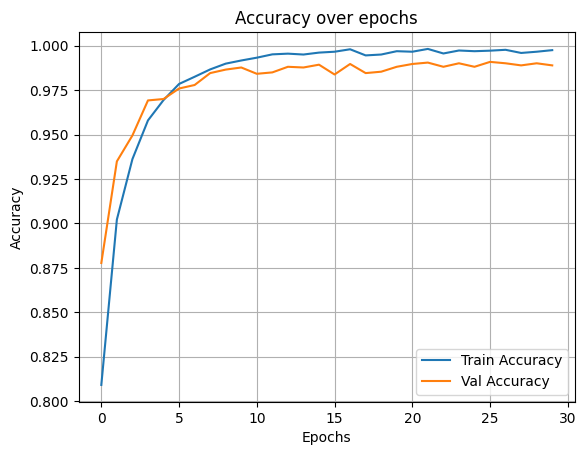

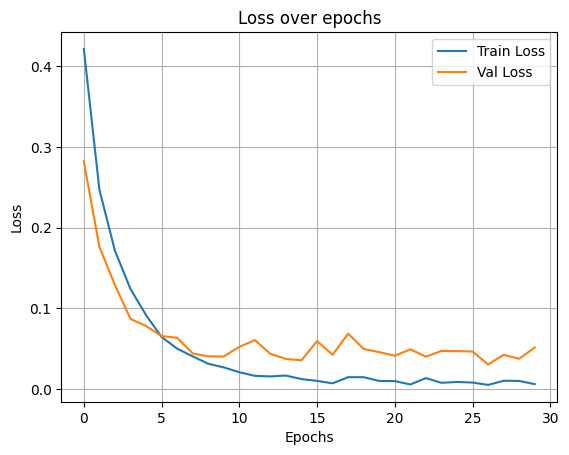

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 3.3.2 Confusion Matrix for CNN Model

Confusion matrix was used for estimation calculation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

model = load_model("best_cnn_model_tumor.h5")

80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step


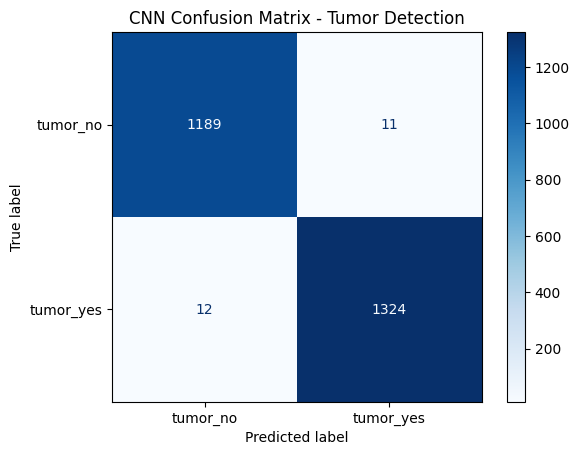

CNN Classification Report:

              precision    recall  f1-score   support

    tumor_no       0.99      0.99      0.99      1200
   tumor_yes       0.99      0.99      0.99      1336

    accuracy                           0.99      2536
   macro avg       0.99      0.99      0.99      2536
weighted avg       0.99      0.99      0.99      2536



In [ ]:
# Prediction
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["tumor_no", "tumor_yes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("CNN Confusion Matrix - Tumor Detection")
plt.grid(False)
plt.show()

# Classification Report
print("CNN Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["tumor_no", "tumor_yes"]))


## 3.4 - VGG16 - Transfer Learning Model

VGG16 Transfer Learning was created for another deep learning model.

**VGG16 - Model Architecture**
*   `base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))` Loads the VGG16 model pre-trained on ImageNet without the top layer. The input shape is set to 64x64 RGB images.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add last layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)


model_vgg16 = Model(inputs=base_model.input, outputs=x)


for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**VGG16 - Model Compilation**

In [ ]:
# Compile
model_vgg16.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

**VGG16 - Earlystop**

In [ ]:
# Earlystop
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

**VGG16 - Model Checkpoint**

Saves the model file with the best validation accuracy. The best validation accuracy was saved "**best_vgg16_model_tumor.h5**" in this vgg16 model.

In [ ]:
# Model Checkpoint
model_checkpoint = ModelCheckpoint(
    'best_vgg16_model_tumor.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
model_vgg16.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,6

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 3.5 - VGG16 - Transfer Learning Model Training

**Model Training - Time Calculation**

In [ ]:
import time
start = time.time()

history_vgg16 = model_vgg16.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7577 - loss: 0.4959
Epoch 1: val_accuracy improved from -inf to 0.84858, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.7579 - loss: 0.4957 - val_accuracy: 0.8486 - val_loss: 0.3401
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8694 - loss: 0.3060
Epoch 2: val_accuracy improved from 0.84858 to 0.90418, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.8694 - loss: 0.3060 - val_accuracy: 0.9042 - val_loss: 0.2389
Epoch 3/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9029 - loss: 0.2491
Epoch 3: val_accuracy improved from 0.90418 to 0.90576, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.9029 - loss: 0.2491 - val_accuracy: 0.9058 - val_loss: 0.2256
Epoch 4/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9082 - loss: 0.2290
Epoch 4: val_accuracy improved from 0.90576 to 0.93336, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.9082 - loss: 0.2290 - val_accuracy: 0.9334 - val_loss: 0.1804
Epoch 5/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9259 - loss: 0.1891
Epoch 5: val_accuracy improved from 0.93336 to 0.93730, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 523s 2s/step - accuracy: 0.9259 - loss: 0.1891 - val_accuracy: 0.9373 - val_loss: 0.1651
Epoch 6/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9271 - loss: 0.1853
Epoch 6: val_accuracy improved from 0.93730 to 0.94913, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 599s 2s/step - accuracy: 0.9271 - loss: 0.1853 - val_accuracy: 0.9491 - val_loss: 0.1474
Epoch 7/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9380 - loss: 0.1645
Epoch 7: val_accuracy improved from 0.94913 to 0.95347, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.9380 - loss: 0.1645 - val_accuracy: 0.9535 - val_loss: 0.1392
Epoch 8/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9442 - loss: 0.1487
Epoch 8: val_accuracy did not improve from 0.95347
317/317 ━━━━━━━━━━━━━━━━━━━━ 597s 2s/step - accuracy: 0.9442 - loss: 0.1487 - val_accuracy: 0.9531 - val_loss: 0.1371
Epoch 9/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9495 - loss: 0.1380
Epoch 9: val_accuracy improved from 0.95347 to 0.95899, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.9495 - loss: 0.1380 - val_accuracy: 0.9590 - val_loss: 0.1223
Epoch 10/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9502 - loss: 0.1322
Epoch 10: val_accuracy did not improve from 0.95899
317/317 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.9502 - loss: 0.1322 - val_accuracy: 0.9515 - val_loss: 0.1306
Epoch 11/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9513 - loss: 0.1281
Epoch 11: val_accuracy improved from 0.95899 to 0.96333, saving model to best_vgg16_model_tumor.h5


317/317 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.9513 - loss: 0.1281 - val_accuracy: 0.9633 - val_loss: 0.1105
Epoch 12/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9588 - loss: 0.1175

KeyboardInterrupt: 

### 3.5.1 - VGG16 Model Training Visualization

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'history_vgg16' is not defined

### 3.5.2 VGG16 Model Confusion Matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

model = load_model("best_vgg16_model.h5")

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step


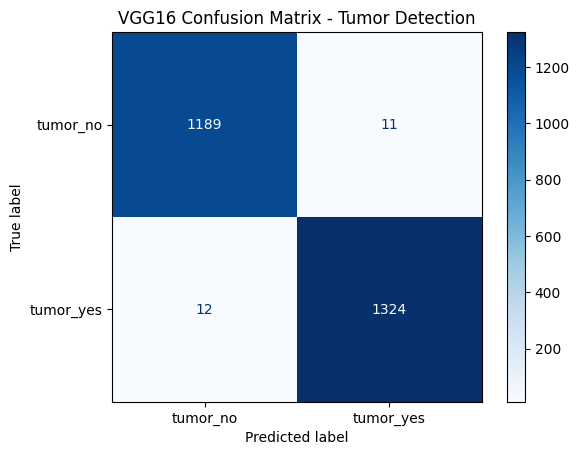

VGG16 Classification Report:

              precision    recall  f1-score   support

    tumor_no       0.99      0.99      0.99      1200
   tumor_yes       0.99      0.99      0.99      1336

    accuracy                           0.99      2536
   macro avg       0.99      0.99      0.99      2536
weighted avg       0.99      0.99      0.99      2536



In [ ]:
# Prediction
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["tumor_no", "tumor_yes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("VGG16 Confusion Matrix - Tumor Detection")
plt.grid(False)
plt.show()

# Classification Report
print("VGG16 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["tumor_no", "tumor_yes"]))

## 3.6 - EfficientNetB0 - Transfer Learning Model

EfficientNetB0 Transfer Learning was created for another deep learning model.

**EfficientNetB0  - Model Architecture**
*   `base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))` Loads the EfficientNetB0 model pre-trained on ImageNet without the top layer. The input shape is set to 64x64 RGB images.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(1, activation='sigmoid')(x)  # Binary classification output


model_efficientnet = Model(inputs=base_model.input, outputs=x)


for layer in base_model.layers:
    layer.trainable = False

**EfficientNetB0 - Model Compilation**

Adam optimizer was used but early stopping function stopped model training at epoch 6 and Epoch 1 was selected as the best model. Therefore, optimizer function was changed.

*   `learning_rate = 0.0001` learning rate value is decreased to increase learning.

In [ ]:
learning_rate = 0.0001  # Learning rate value
optimizer = Adam(learning_rate=learning_rate)


model_efficientnet.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

**EfficientNetB0 - Early Stop**

In [ ]:
# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

**EfficientNetB0 - Checkpoint**

In [ ]:
# Checkpoint
model_checkpoint = ModelCheckpoint(
    'best_efficientnet_model_tumor.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
model_efficientnet.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 64, 64, 3)      │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 65, 65, 3)      │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 32, 32, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 32, 32, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 32, 32, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 32, 32, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 32, 32, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 32, 32, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 3.7 - EfficientNetB0 - Transfer Learning Model Training

**Model Training - Time Calculation**

In [ ]:
import time
start = time.time()

history_efficientnet = model_efficientnet.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6368 - loss: 0.6643
Epoch 1: val_accuracy improved from -inf to 0.64981, saving model to best_efficientnet_model.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 50s 155ms/step - accuracy: 0.6368 - loss: 0.6643 - val_accuracy: 0.6498 - val_loss: 0.6529
Epoch 2/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6449 - loss: 0.6559
Epoch 2: val_accuracy did not improve from 0.64981
257/257 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.6449 - loss: 0.6559 - val_accuracy: 0.6498 - val_loss: 0.6466
Epoch 3/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6556 - loss: 0.6490
Epoch 3: val_accuracy did not improve from 0.64981
257/257 ━━━━━━━━━━━━━━━━━━━━ 32s 119ms/step - accuracy: 0.6555 - loss: 0.6491 - val_accuracy: 0.6498 - val_loss: 0.6468
Epoch 4/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6506 - loss: 0.6510
Epoch 4: val_accuracy did not improve from 0.64981
257/257 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.6506 - loss: 0.6510 - val_accuracy: 0.6498 - val_loss: 0.6475
Epoch 5/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6488 - loss: 0.6507
Epoch 5: val_accur

### 3.7.1 - EfficientNetB0 Training Visualization

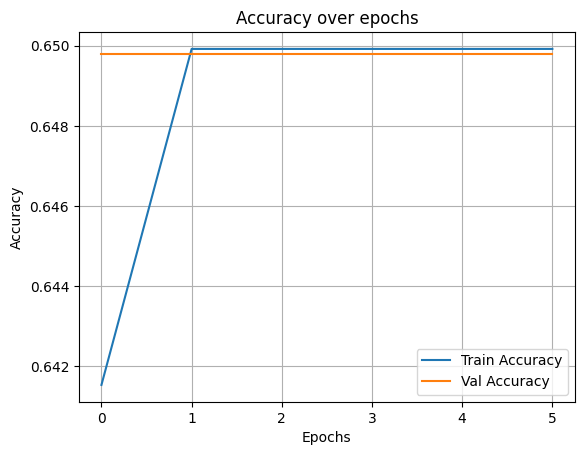

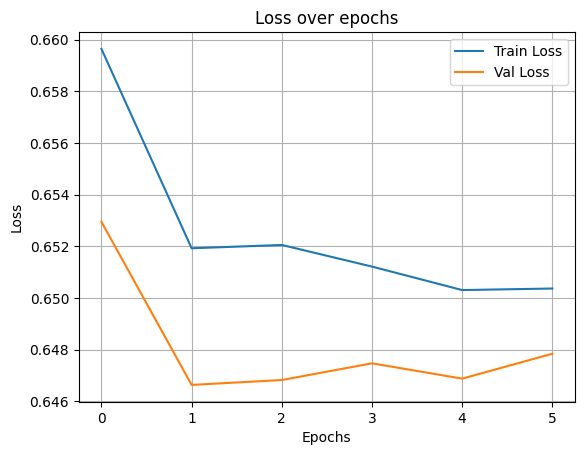

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 3.7.2 - EfficientNetB0 Confusion Matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model

model = load_model("best_efficientnet_model.h5")

65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step


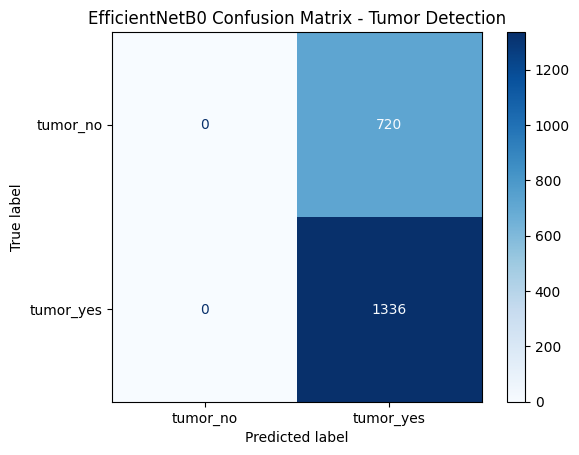

EfficientNetB0 Classification Report:

              precision    recall  f1-score   support

    tumor_no       0.00      0.00      0.00       720
   tumor_yes       0.65      1.00      0.79      1336

    accuracy                           0.65      2056
   macro avg       0.32      0.50      0.39      2056
weighted avg       0.42      0.65      0.51      2056



In [ ]:
# Prediction
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["tumor_no", "tumor_yes"])
disp.plot(cmap=plt.cm.Blues)
plt.title("EfficientNetB0 Confusion Matrix - Tumor Detection")
plt.grid(False)
plt.show()

# Classification Report
print("EfficientNetB0 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["tumor_no", "tumor_yes"]))

## 3.8 - ResNet50 - Transfer Learning Model

 ResNet50 Transfer Learning was created for another deep learning model.

**ResNet50  - Model Architecture**
*   base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))` Loads the EfficientNetB0 model pre-trained on ImageNet without the top layer. The input shape is set to 64x64 RGB images.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)


model_resnet50 = Model(inputs=base_model.input, outputs=x)


for layer in base_model.layers:
    layer.trainable = False

**ResNet50 - Model Compilation**

In [ ]:
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

**ResNet50 - Early Stop**

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

**ResNet50 - Checkpoint**

In [ ]:
model_checkpoint = ModelCheckpoint(
    'best_resnet_model_tumor.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
model_resnet50.summary()

## 3.9 - ResNet50 - Transfer Learning Model Training

**Model Training - Time Calculation**

In [ ]:
import time
start = time.time()

history_resnet = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")